In [ ]:
 # Download dataset from Kaggle
!pip install -q kaggle
from google.colab import files
# files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d feyzazkefe/TrashNet

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/feyzazkefe/TrashNet
License(s): unknown
 91% 37.0M/40.8M [00:00<00:00, 72.0MB/s]
100% 40.8M/40.8M [00:00<00:00, 68.0MB/s]


In [ ]:
! unzip 'TrashNet.zip' -d '/content/'

Archive:  TrashNet.zip
  inflating: /content/dataset-resized/cardboard/cardboard1.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard10.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard100.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard101.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard102.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard103.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard104.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard105.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard106.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard107.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard108.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard109.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard11.jpg  
  inflating: /content/dataset-resized/cardboard/cardboard110.jpg  
  inflating: /content/dataset-resized/cardb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import multiprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**DEFINING THE MODEL**

In [ ]:
def accuracy(outputs, labels):  # outputs is the output of the model, labels is the actual label of the image
    _, preds = torch.max(outputs, dim=1)  # preds is the predicted label of the image
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))  # returns the accuracy of the model

class ImageClassification(nn.Module):  # nn.Module is the base class for all neural network modules
    def training_step(self, batch):  # This function is used to train the model
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)  # Calculate accuracy
        return loss

    def validating(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'Validation Loss': loss.detach(), 'Validation Accuracy': acc}

    def validating_epoch_final(self, outputs):
        batch_loss = [x['Validation Loss'] for x in outputs]  # This line extracts the validation loss for
        # each batch of the validation data
        epoch_loss = torch.stack(batch_loss).mean()  # This line calculates the mean of the validation loss for all batches
        batch_accuracy = [x['Validation Accuracy'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'Validation Loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}

    def epoch_final(self, epoch, result):
        print("Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
              .format(epoch + 1, result['Training Loss'], result['Validation Loss'], result['Validation Accuracy']))

**USING ResNet50 FOR CLASSIFICATION**

In [ ]:
class ResNet(ImageClassification):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

**DEFINE A BLOCK**

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


def ResNet50(img_channels=3, num_classes=13):
    return ResNet(Block, [3, 4, 6, 3], img_channels, num_classes)

**EXPORT CLASSIFICATION METRICS**

In [ ]:
def export_classification_metrics(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)  # Move images to GPU if available
            labels = labels.to(device)  # Move labels to GPU if available

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    for i, class_name in enumerate(classes):
        class_labels = [1 if label == i else 0 for label in all_labels]
        class_preds = [1 if pred == i else 0 for pred in all_preds]

        accuracy = accuracy_score(class_labels, class_preds) * 100
        precision = precision_score(class_labels, class_preds, zero_division=0) * 100
        recall = recall_score(class_labels, class_preds, zero_division=0) * 100
        f1 = f1_score(class_labels, class_preds, zero_division=0) * 100

        print(f'{class_name}, accuracy: {accuracy:.2f}%, precision: {precision:.2f}%, recall: {recall:.2f}%, F1 score: {f1:.2f}%')

**LOADING THE DATASET**

In [ ]:
directory = '/kaggle/input/trashnet/dataset-resized'
global garbage_classes
garbage_classes = os.listdir(directory)
print(garbage_classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


**TRANSFORMING THE DATASETS**

In [ ]:
# Importing Transforms to modify the images
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Resize all images to 224x224 pixels and converting to Tensor
transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Load the dataset and apply the transformations
dataset = ImageFolder(directory, transform=transformations)

**TESTING THE DATASETS BY RANDOMLY DISPLAYING IMAGES AND THEIR LABELS**

Label: glass (Class No: 1)


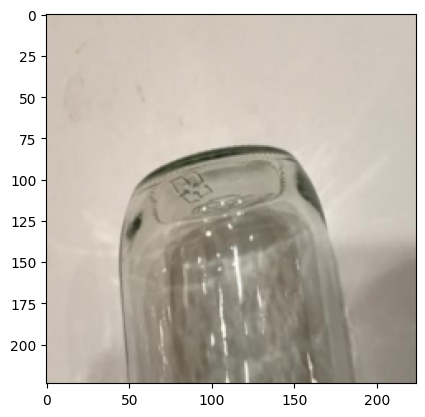

In [ ]:
# Permute the dimensions of the image to fit the format of the matplotlib
def display_test(image, label):
    print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Display a random image from the dataset
image, label = dataset[random.randint(0, len(dataset))]
display_test(image, label)

**SETTING RANDOM SEED FOR REPRODUCIBILITY**

In [ ]:
random_seed = 43
torch.manual_seed(random_seed)

**SPLITTING DATASET & DEFINING BATCH SIZE**

In [ ]:
train_size = int(0.6 * len(dataset))  # 60% of the dataset
val_size = int(0.2 * len(dataset))  # 20% of the dataset
test_size = len(dataset) - train_size - val_size  # Remaining 20% of the dataset
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
from torch.utils.data.dataloader import DataLoader
batch_size = 64

**CREATING THE DATALOADERS**

In [ ]:
train = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation = DataLoader(val_data, batch_size * 2, num_workers=4, pin_memory=True)

**BATCH VISUALIZATION**

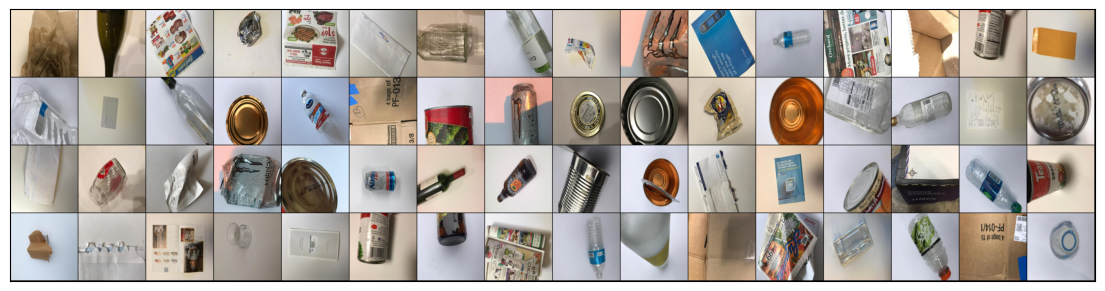

Processing via: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
from torchvision.utils import make_grid
def batch_visualization(data):
    for image, labels in data:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]);
        ax.set_yticks([])
        ax.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
        plt.show()
        break

batch_visualization(train)
model = ResNet50()

# Porting the model to GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

# Move the model to GPU
def move_to_gpu(data, device):
    # Move Tensor to GPU
    if isinstance(data, (list, tuple)):
        return [move_to_gpu(x, device) for x in data]
    return data.to(device, non_blocking=True)

# DataLoading Class
class DataLoad():
    def __init__(self, data, device):
        self.data = data
        self.device = get_default_device()

    # Yields batch after moving to device
    def __iter__(self):
        for batch in self.data:
            yield move_to_gpu(batch, self.device)

    # Returns the length of the data
    def __len__(self):
        return len(self.data)

device = get_default_device()
print('Processing via:', device)  # Note: If output is Cuda, then GPU is available

train = DataLoad(train, device)
validation = DataLoad(validation, device)
move_to_gpu(model, device)

**MODEL TRAINING**

In [ ]:
@torch.no_grad()
def evaluate(model, validator):
    model.eval()  # Evaluation Mode
    outputs = [model.validating(batch) for batch in validator]
    return model.validating_epoch_final(outputs)

def opt(epochs, learning_rate, model, train_loader, validator, opt_func=torch.optim.SGD):
    training_history = []  # List to store the training history
    optimizer = opt_func(model.parameters(), learning_rate)
    for epoch in range(epochs):  # Loop for each epoch

        # Training Step
        model.train()  # Training Mode
        train_loss = []  # List to store the training loss
        for batch in train_loader:  # Loop for each batch
            loss = model.training_step(batch)  # Calculate the loss
            train_loss.append(loss)  # Append the loss to the list
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the parameters using the optimizer
            optimizer.zero_grad()  # Reset the gradients to zero for the next batch

        # Validation phase
        result = evaluate(model, validator)  # Evaluate the model on the validation set
        result['Training Loss'] = torch.stack(train_loss).mean().item()  # Calculate the average training loss
        model.epoch_final(epoch, result)  # Call the epoch_final method on the model
        training_history.append(result)  # Append the results to the training history
    return training_history

model = move_to_gpu(ResNet50(), device)
evaluate(model, validation)

{'Validation Loss': 2.5906829833984375, 'Validation Accuracy': 0.0}

**DEFINING HYPERPARAMETERS**

In [ ]:
epoch = 100
optimizer = torch.optim.Adam
learning_rate = 0.00005
model_history = opt(epoch, learning_rate, model, train, validation, optimizer)

Epoch [1], Training Loss: 1.9359, Validation Loss: 2.4219, Validation Accuracy: 0.1964
Epoch [2], Training Loss: 1.1323, Validation Loss: 1.7291, Validation Accuracy: 0.3446
Epoch [3], Training Loss: 0.9048, Validation Loss: 1.2038, Validation Accuracy: 0.5717
Epoch [4], Training Loss: 0.7426, Validation Loss: 1.2417, Validation Accuracy: 0.5783
Epoch [5], Training Loss: 0.6956, Validation Loss: 1.1899, Validation Accuracy: 0.6097
Epoch [6], Training Loss: 0.5441, Validation Loss: 1.1164, Validation Accuracy: 0.6257
Epoch [7], Training Loss: 0.4233, Validation Loss: 1.2603, Validation Accuracy: 0.6615
Epoch [8], Training Loss: 0.3457, Validation Loss: 1.2312, Validation Accuracy: 0.6373
Epoch [9], Training Loss: 0.2996, Validation Loss: 1.2543, Validation Accuracy: 0.6414
Epoch [10], Training Loss: 0.3356, Validation Loss: 1.5367, Validation Accuracy: 0.6074
Epoch [11], Training Loss: 0.2918, Validation Loss: 1.5910, Validation Accuracy: 0.6358
Epoch [12], Training Loss: 0.2597, Valida

**PLOTTING THE ACCURACY VS EPOCHS**

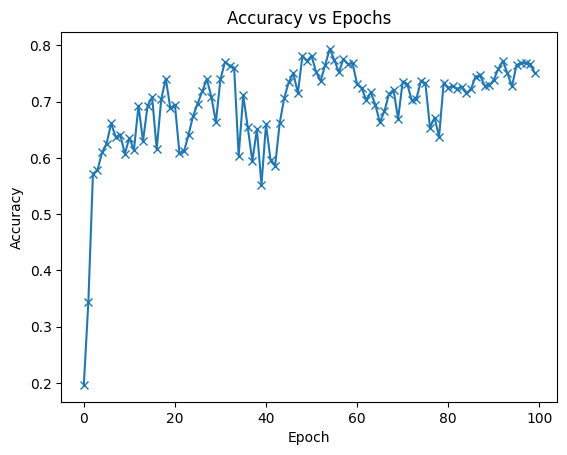

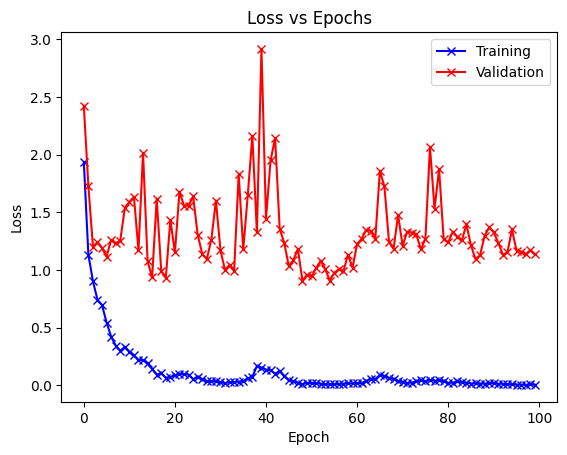

In [ ]:
def plot_accuracy(model_history):
    accuracies = [x['Validation Accuracy'] for x in model_history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.show()

plot_accuracy(model_history)

def plot_loss(model_history):
    train_loss = [x.get('Training Loss') for x in model_history]
    validation_loss = [x['Validation Loss'] for x in model_history]
    plt.plot(train_loss, '-bx')
    plt.plot(validation_loss, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs Epochs')
    plt.show()

plot_loss(model_history)

**PLOTTING THE CONFUSION MATRIX**

<Figure size 1000x1000 with 0 Axes>

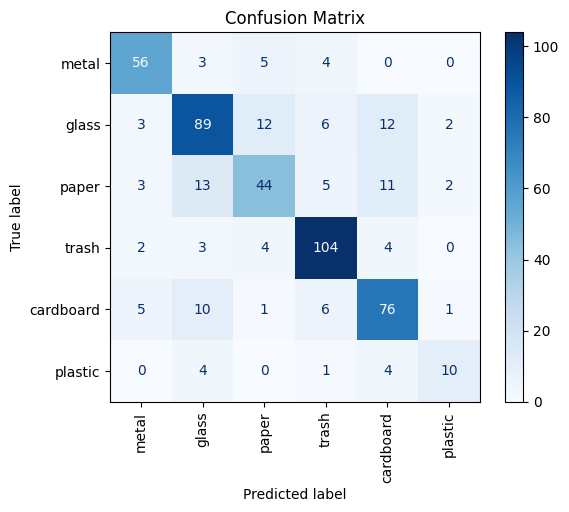

In [ ]:
def plot_confusion_matrix(model, dataloader, classes):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = move_to_gpu(images, device)  # Move images to GPU if available
            labels = labels.to(device)  # Move labels to GPU if available

            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()
plot_confusion_matrix(model, validation, garbage_classes)

In [ ]:
export_classification_metrics(model, validation, garbage_classes)

metal, accuracy: 95.05%, precision: 81.16%, recall: 82.35%, F1 score: 81.75%
glass, accuracy: 86.53%, precision: 72.95%, recall: 71.77%, F1 score: 72.36%
paper, accuracy: 88.91%, precision: 66.67%, recall: 56.41%, F1 score: 61.11%
trash, accuracy: 93.07%, precision: 82.54%, recall: 88.89%, F1 score: 85.60%
cardboard, accuracy: 89.31%, precision: 71.03%, recall: 76.77%, F1 score: 73.79%
plastic, accuracy: 97.23%, precision: 66.67%, recall: 52.63%, F1 score: 58.82%


**VISUALIZE THE PREDICTIONS**

In [ ]:
def predict(image, model):
    # Convert to a batch of 1
    xb = move_to_gpu(image.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

**TESTING NO.1**

Testing No.1 - Class: paper , Predicted Class: paper


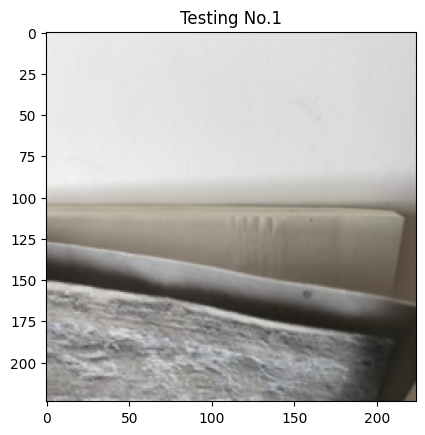

In [ ]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))  # Permuting the image to the format expected by matplotlib
print('Testing No.1 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.1')
plt.show()

**TESTING NO.2**

Testing No.2 - Class: plastic , Predicted Class: glass


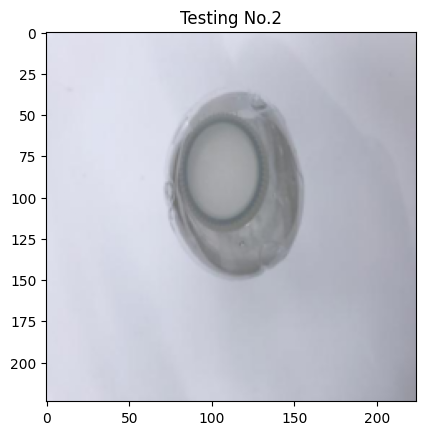

In [ ]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))  # Permuting the image to the format expected by matplotlib
print('Testing No.2 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.2')
plt.show()

**TESTING NO.3**

Testing No.3 - Class: paper , Predicted Class: paper


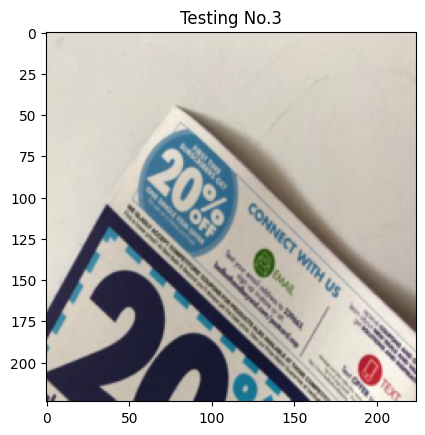

In [ ]:
img, label = random.choice(dataset)
plt.imshow(img.permute(1, 2, 0))  # Permuting the image to the format expected by matplotlib
print('Testing No.3 - Class:', dataset.classes[label], ', Predicted Class:', predict(img, model))
plt.title('Testing No.3')
plt.show()

**SAVING THE MODEL**

In [ ]:
FILE = "/kaggle/working/ResnetModel.pth"
model_scripted = torch.jit.script(model)
torch.jit.save(model_scripted, FILE)